# Probabilistic Forecasting
> Quantify uncertainty

Probabilistic forecasting is a natural answer to quantify the uncertainty of target variable's future. The task requires
to model the following conditional predictive distribution:

$$\mathbb{P}(\mathbf{y}_{t+1:t+H} \;|\; \mathbf{y}_{:t})$$

We will show you how to tackle the task with `NeuralForecast` by combining a classic Long Short Term Memory Network [(LSTM)](https://arxiv.org/abs/2201.12886) and the Neural Hierarchical Interpolation [(NHITS)](https://arxiv.org/abs/2201.12886) with the multi quantile loss function (MQLoss).

$$ \mathrm{MQLoss}(y_{\tau}, [\hat{y}^{(q1)}_{\tau},\hat{y}^{(q2)}_{\tau},\dots,\hat{y}^{(Q)}_{\tau}]) = \frac{1}{H} \sum_{q} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) $$

In this notebook we will:<br>
1. Install NeuralForecast Library<br>
2. Explore the M4-Hourly data.<br>
3. Train the LSTM and NHITS<br>
4. Visualize the LSTM/NHITS prediction intervals.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

#### Useful functions

The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import matplotlib.pyplot as plt

def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'{model}-lo-{l}'], 
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## 2. Loading M4 Data

For testing purposes, we will use the Hourly dataset from the [M4 competition](https://www.researchgate.net/publication/325901666_The_M4_Competition_Results_findings_conclusion_and_way_forward).

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [ ]:
import pandas as pd

In [ ]:
Y_train_df = pd.read_csv('M4-Hourly.csv')
Y_test_df = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

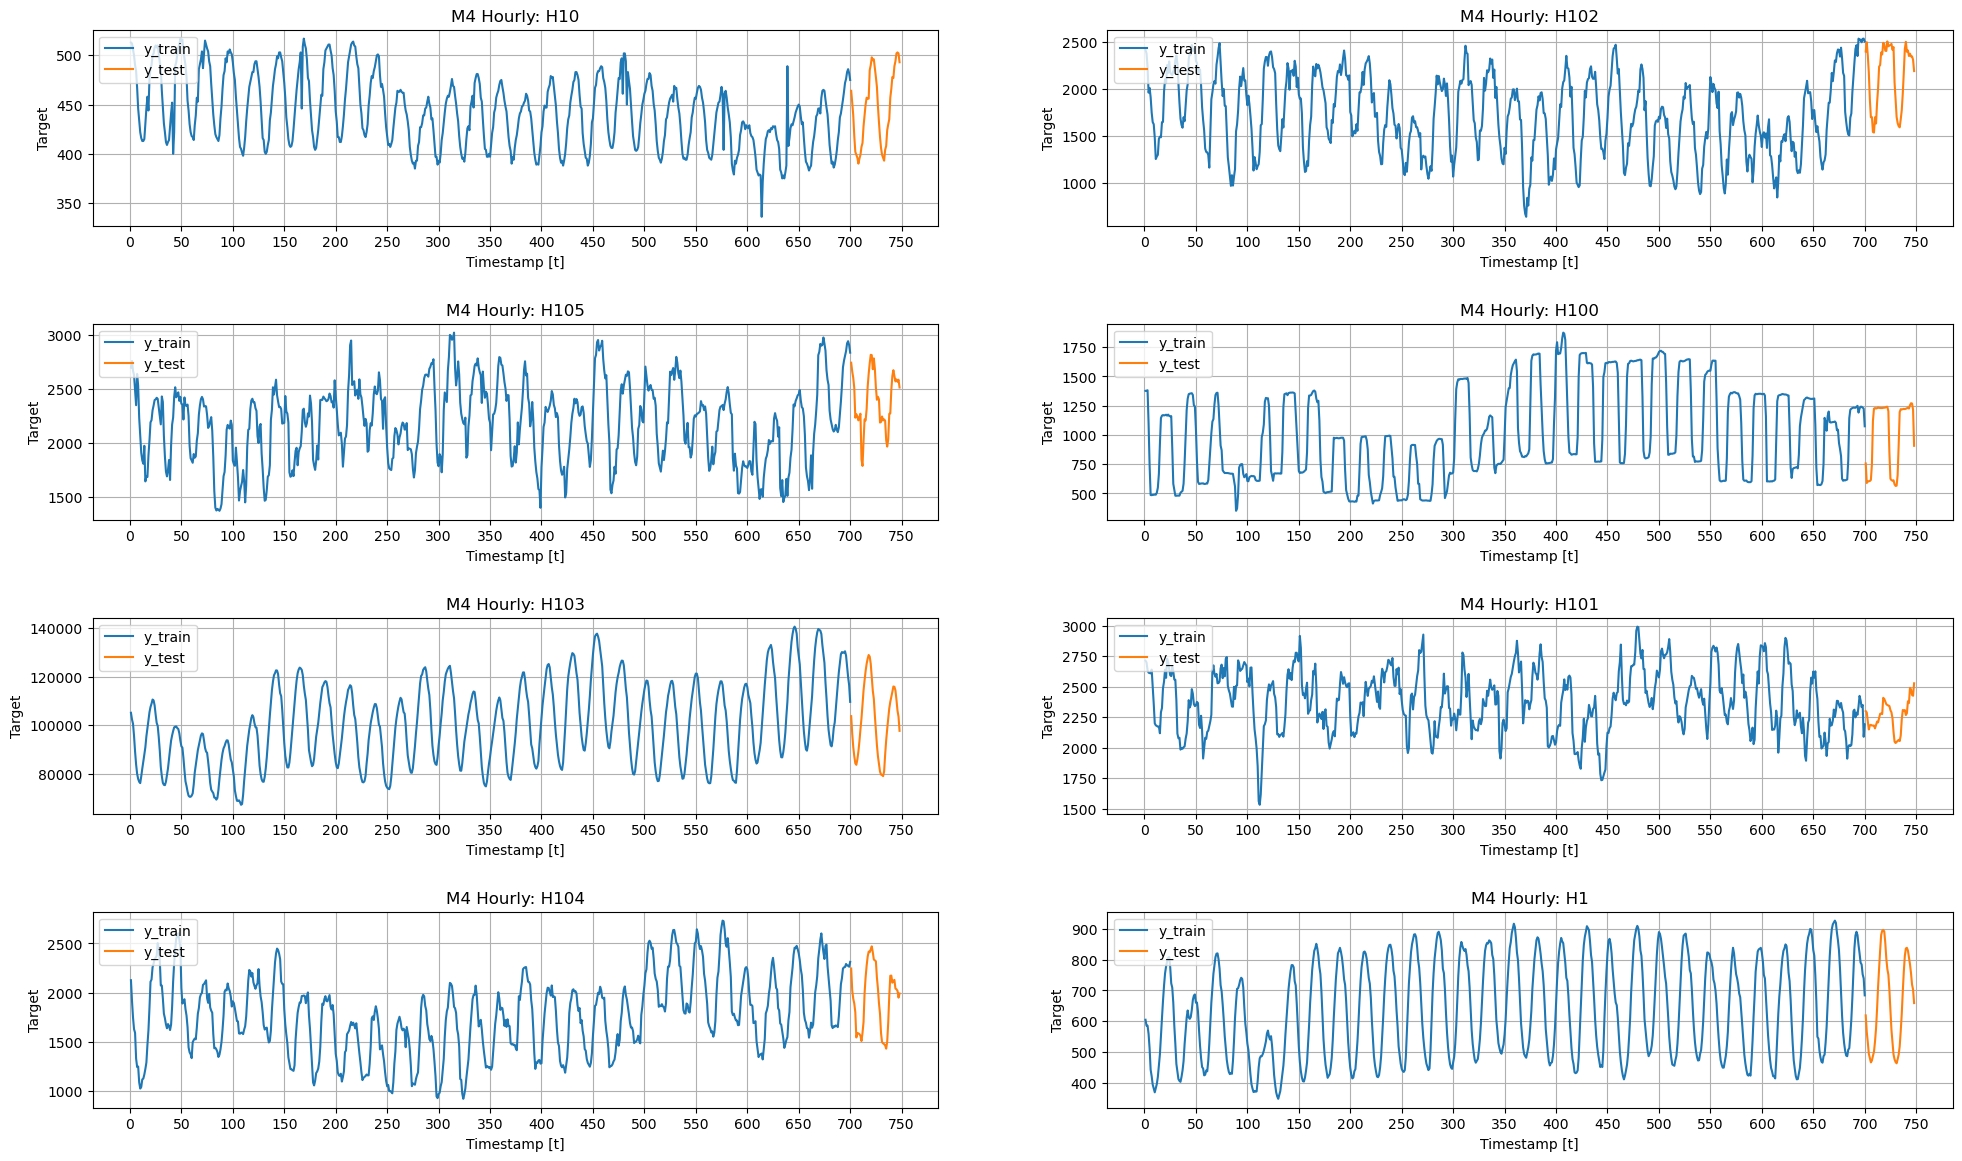

In [ ]:
plot_grid(Y_train_df, Y_test_df)

## 3. Model Training

The `core.NeuralForecast` provides a high-level interface with our collection of PyTorch models. 
`NeuralForecast` is instantiated with a list of `models=[LSTM(...), NHITS(...)]`, configured for the forecasting task.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `MQLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals. 
- The `max_steps=2000`, controls the duration of the network's training.

For more network's instantiation details check their [documentation](https://nixtla.github.io/neuralforecast/models.dilated_rnn.html).

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, NHITS

In [ ]:
horizon = 48
levels = [80, 90]
models = [LSTM(input_size=3*horizon, h=horizon,
               loss=MQLoss(level=levels), max_steps=1000),
          NHITS(input_size=7*horizon, h=horizon,
                n_freq_downsample=[24, 12, 1],
                loss=MQLoss(level=levels), max_steps=2000),]
nf = NeuralForecast(models=models, freq='H')

Global seed set to 1
Global seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [ ]:
%%capture
nf.fit(df=Y_train_df)

In [ ]:
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.22it/s]


,unique_id,ds,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90
0,H1,701,603.491211,526.534119,544.686646,650.893799,673.805603,611.634888,575.999146,582.778687,677.277039,674.705872
1,H1,702,548.415710,438.868591,472.805237,608.017822,639.063293,569.997803,513.014282,518.707153,598.849609,616.793457
2,H1,703,502.010681,382.608643,411.710419,570.315308,608.669250,510.787628,454.184448,465.425232,538.964172,554.563354
3,H1,704,460.870483,339.368988,370.636719,544.232666,579.824402,478.482330,429.657104,452.395508,500.892090,502.507141
4,H1,705,436.451843,313.868744,343.514191,520.812988,559.734741,463.763611,432.906342,427.853577,486.854492,487.539062


In [ ]:
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

## 4. Plotting Predictions

Here we finalize our analysis by plotting the prediction intervals and verifying that both the `LSTM` and `NHITS` are giving excellent results.

Consider the output `[NHITS-lo-90.0`, `NHITS-hi-90.0]`, that represents the 80% prediction interval of the `NHITS` network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

### LSTM

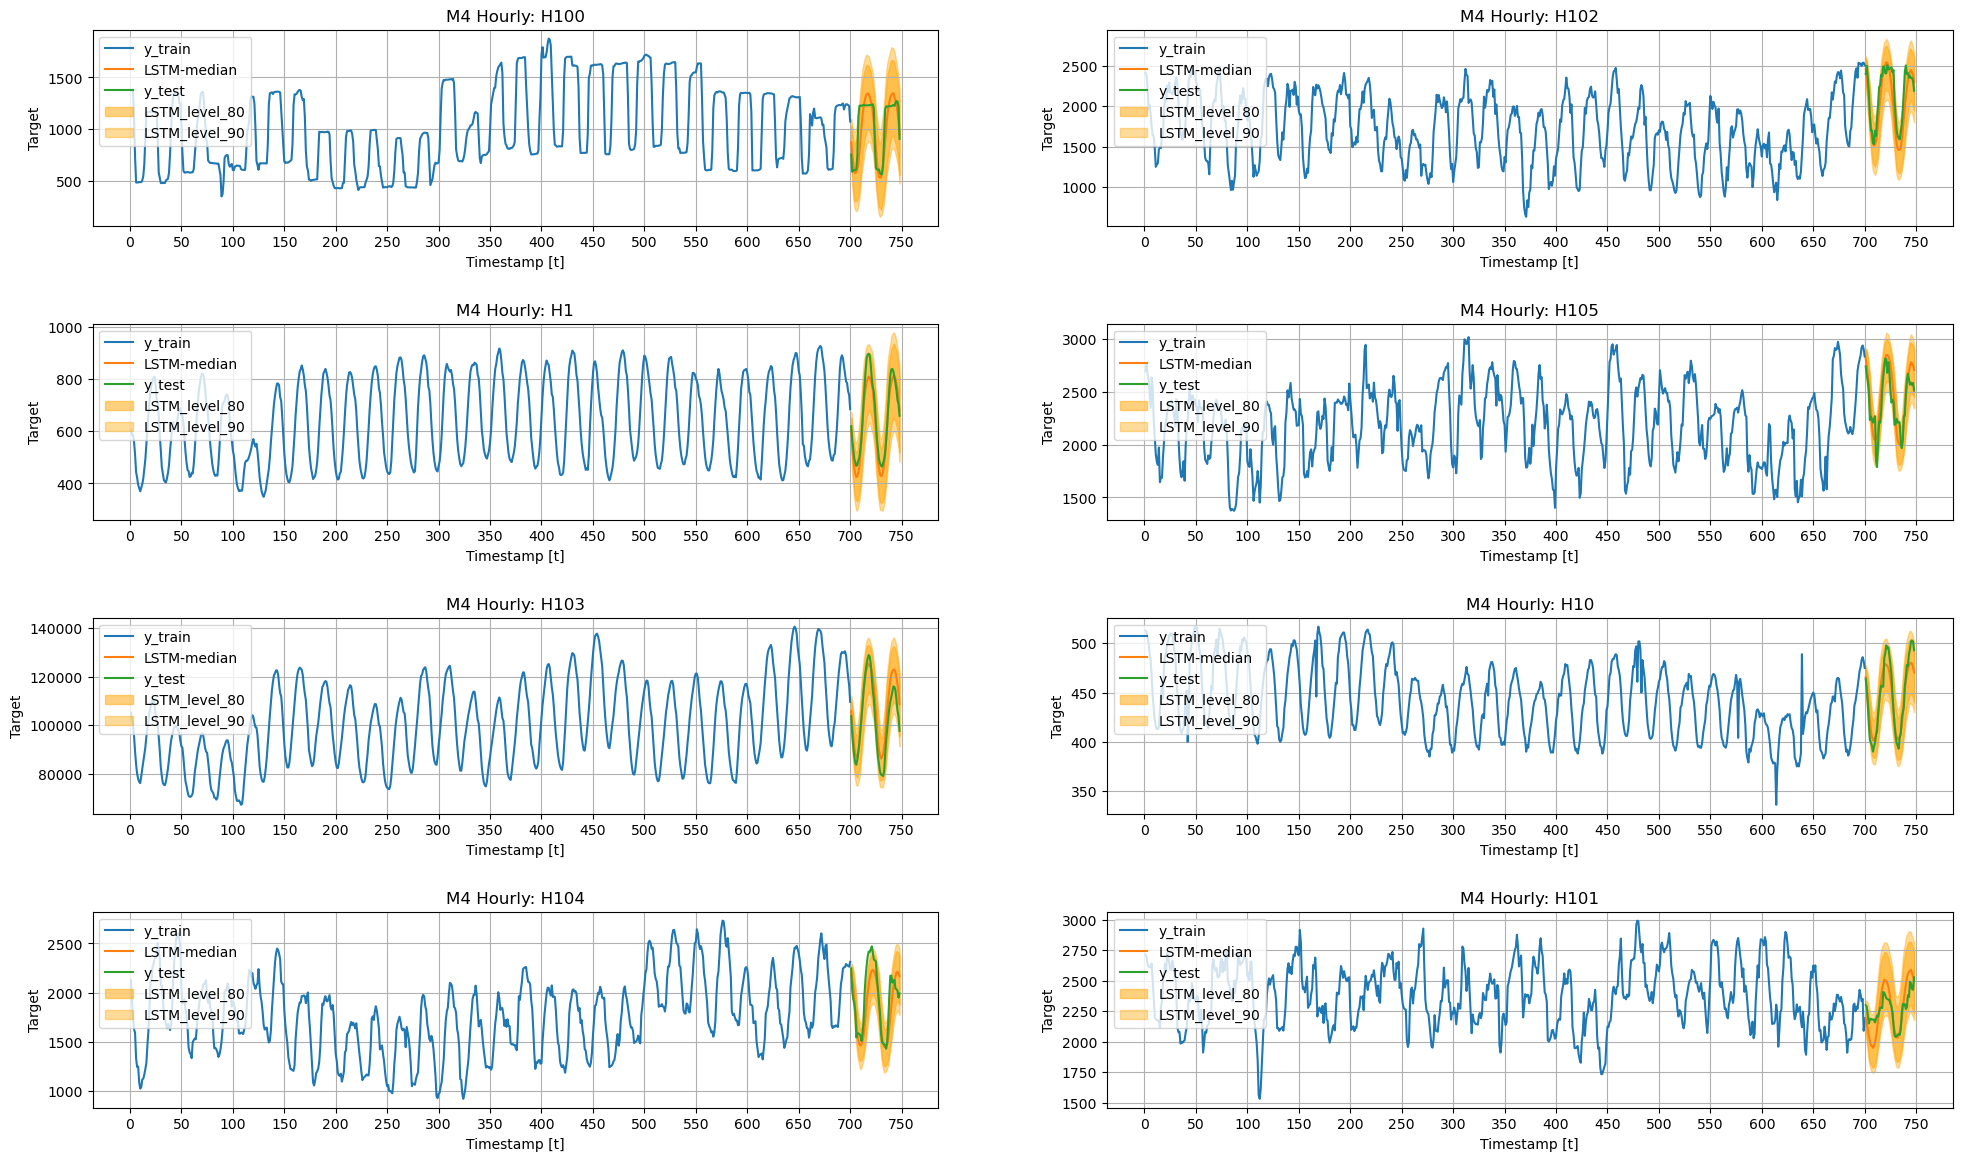

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM')

### NHITS

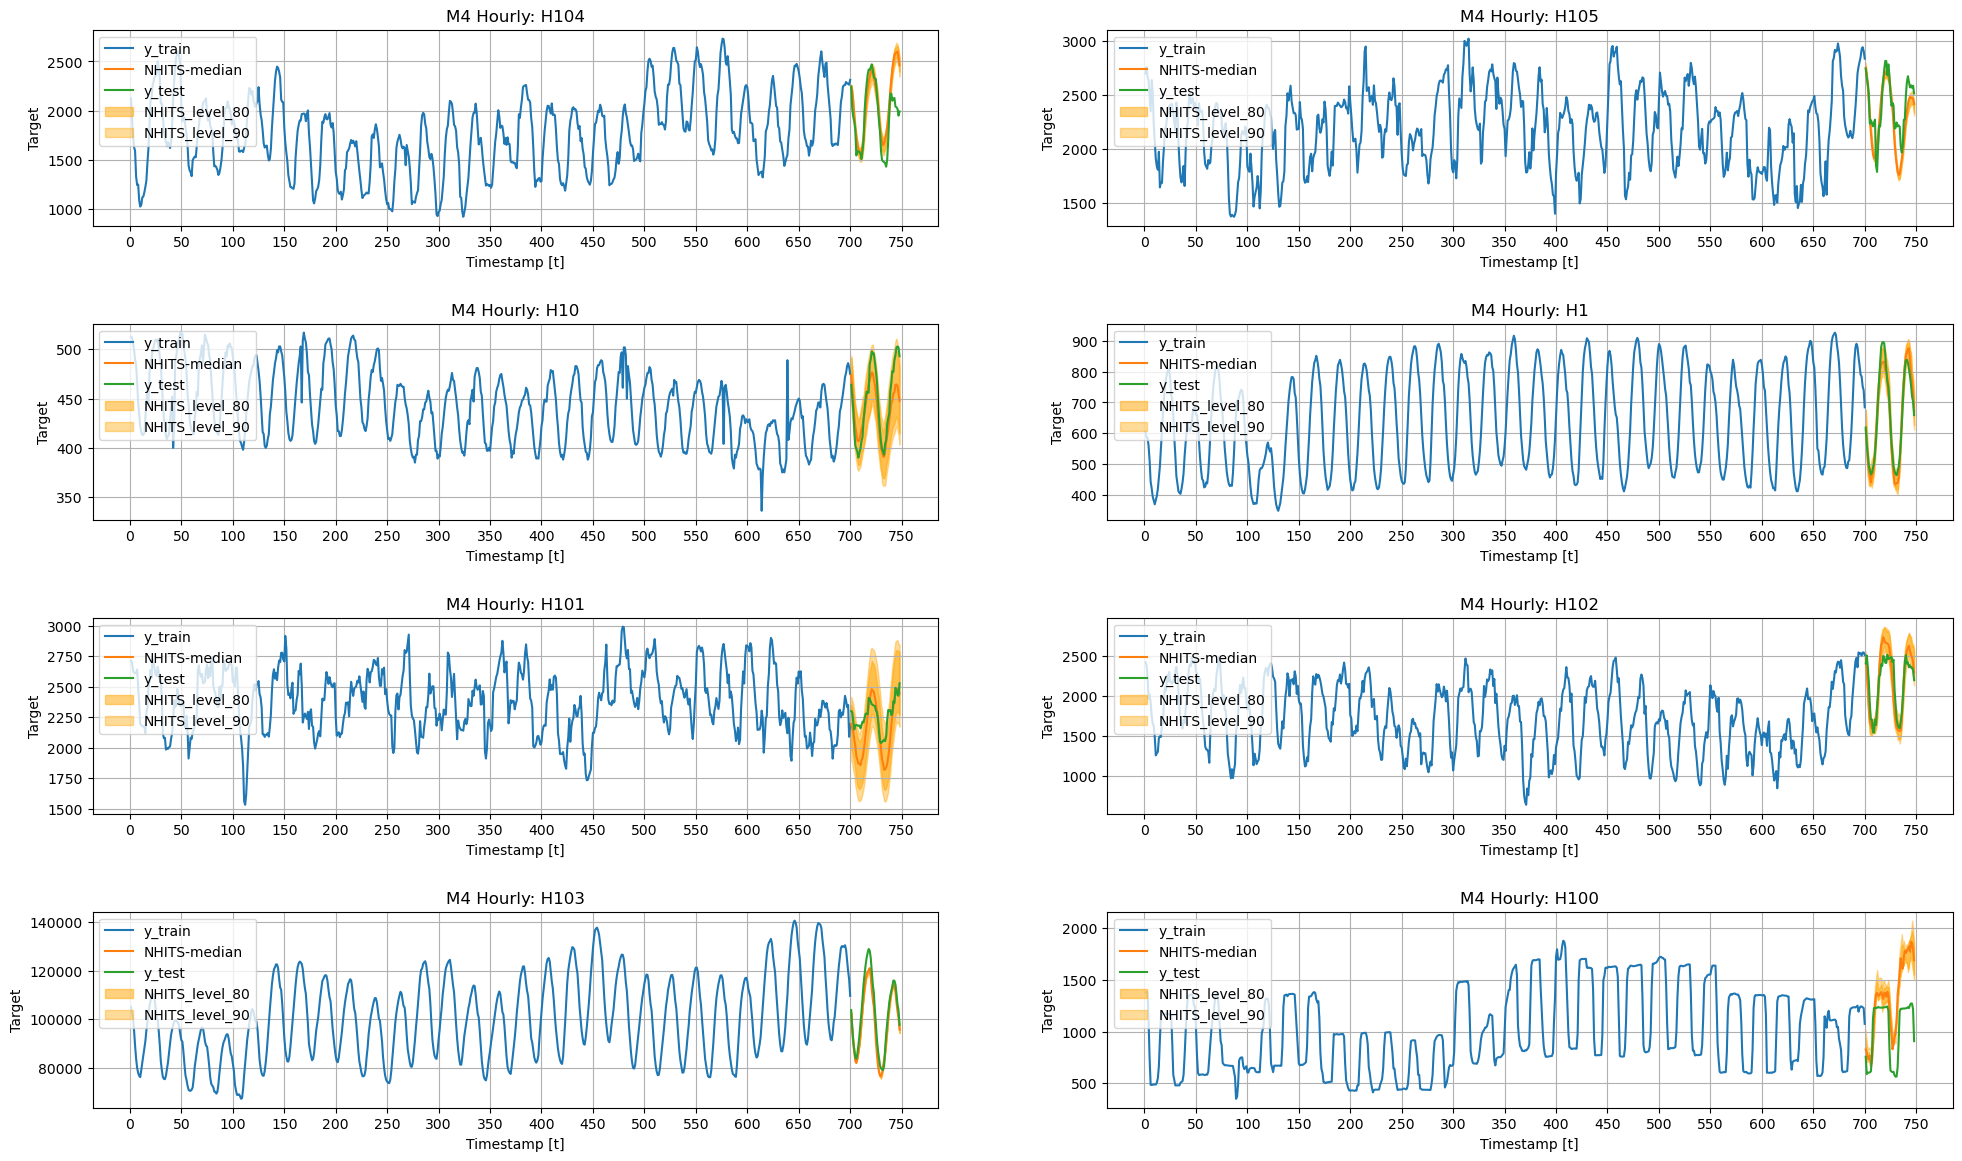

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='NHITS')

## References
- [Roger Koenker and Gilbert Basset (1978). Regression Quantiles, Econometrica.](https://www.jstor.org/stable/1913643)<br>
- [Jeffrey L. Elman (1990). "Finding Structure in Time".](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1)<br>
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)<br>